As a review from the previous blog post, Markov Chains are a way to describe processes that have multiple states. For instance, a switch might be flipped to option A, B, or C. Each of these states has an associated probability of transitioning from one state to another state, and we can construct a "transition probability matrix" which describes the chance of transitioning from one state to another state. The Markov, or "memoryless" assumption, predicts the future state based only on the value of the current state.

In this case, we will be investigating a Markov Chain with three possible states:

[Image in blog post]

Markov Chains are often useful to consider for my domain of expertise, equipment condition-monitoring. Over a given time history, equipment may be considered to operate under different conditions, which might cause damage to the equipment at different rates. For example, operating a generator under high load will accrue more damage than operating under the rated load. Based on the image above, assume that the states refer to the generator load: "low load", "normal load", and "high load".

The simulation from the previous blog post will be modified so that there are three possible states, not two. Also, we will keep track of the degradation of the equipment, under the assumption that the equipment fails when the degradation reaches a hard threshold. Note that there are several simplifying assumptions for this example which make it much less practical for real-life applications. Equipment typically fail under a distribution of accrued damage rather than a hard threshold. Furthermore, the amount of damage accrued while operating in a particular state is not likely to be constant. If I were developing this model for production, it would be much more extensive; this analysis is useful as an example of what might be accomplished with Markov Chain analysis alone.

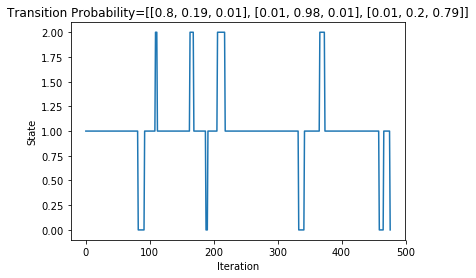

In [1]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Since the Markov assumption requires that the future 
# state only depends on the current state, we will keep
# track of the current state during each iteration.
# "0" is low, "1" is normal, and "2" is high
def MCDegradeSim(t_prob, d_per_state, d_thresh):
    # As the number of states increase, the initial state
    # below might make a difference, so be careful.
    cur_state = 1
    cur_deg = 0
    res = []
    deg = []
    # "while True" is usually a bad idea, but I know that the while
    # loop must terminate, because the accrued degradation is 
    # always positive
    while True:
        rn = random.random()
        # Contrary to the previous blog post, this will be
        # done with much more coding efficiency.
        if rn<=t_prob[cur_state][0]:
            cur_state = 0
            cur_deg += d_per_state[0]
        # Remember that it's the cumulative probability
        elif rn<=(t_prob[cur_state][0] + t_prob[cur_state][1]):
            cur_state = 1
            cur_deg += d_per_state[1]
        else:
            cur_state = 2
            cur_deg += d_per_state[2]
        # Save the results to an array
        res.append(cur_state)
        deg.append(cur_deg)
        # If the degradation is above the threshold, the 
        # simulation is done
        if cur_deg>d_thresh:
            break
    return res
# Transition probability matrix, taken from the image above
tpm = [[0.8, 0.19, 0.01],[0.01, 0.98, 0.01],[0.01, 0.2, 0.79]]
# Don't cheat and look at this! This is the degradation 
# accrued per state and the damage threshold
dps = [0.5, 0.1, 1.5]
deg_thresh = 100
# Run and plot the results
res = MCDegradeSim(tpm, dps, deg_thresh)
plt.plot(res)
plt.title('Transition Probability=' + str(tpm))
plt.xlabel('Iteration')
plt.ylabel('State');

Note that the probability of transitioning to a normal state is higher than for the other states, so the simulation spends much more time in the "normal" state. Think of state "2" and state "0" as stressful operating conditions which decrease the expected lifetime of the equipment. Compare the number of iterations above (~500) to the following example, where an equipment spends more time in a stressful condition.

[Image in blog post]

Let's modify the transition probability matrix accordingly:

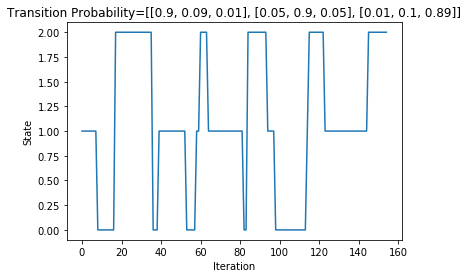

In [2]:
# The new transition probability matrix
tpm2 = [[0.9, 0.09, 0.01],[0.05, 0.90, 0.05],[0.01, 0.1, 0.89]]
res2 = MCDegradeSim(tpm2, dps, deg_thresh)
plt.plot(res2)
plt.title('Transition Probability=' + str(tpm2))
plt.xlabel('Iteration')
plt.ylabel('State');

Based on the figure above, the equipment fails more quickly (~150 iterations) and also spends more time in the "low load" and "high load" states, since we increased the probabilities of staying/transitioning to those two states.

Assuming that you didn't already look at the damage accrued per state in the code above, we can actually use the data itself to estimate it. Let's imagine that we have 100 examples of equipment failures (in real life, this is a *very* big assumption):

In [3]:
num_failures = 100
# Run the MCDegradeSim function for num_failures
res_array = []
for ii in range(num_failures):
    res = MCDegradeSim(tpm, dps, deg_thresh)
    res_array.append(res)

Now, let's count up all the transitions in the data, to see if we can obtain the original transition probability matrix (assuming that we didn't already know it).

In [4]:
import numpy as np
# Keep track of the transitions from/to each state 
trans_matrix = np.zeros((3,3))
# "hist" is the time history for a single equipment
for hist in res_array:
    # Iterate over each state in the time history,
    # and find the transitions between an old state
    # and a new state.
    for ii, state in enumerate(hist):
        old_state = hist[ii-1]
        new_state = hist[ii]
        trans_matrix[old_state, new_state] += 1
# To translate the matrix into probabilities, 
# divide by the total
trans_prob = trans_matrix/(sum(trans_matrix))
print(trans_prob.transpose())

[[ 0.79447853  0.19631902  0.00920245]
 [ 0.00945287  0.98084849  0.00969864]
 [ 0.01567262  0.21811058  0.7662168 ]]


As can be seen, the above code approximates the original transition probability matrix fairly well. (Compare the above matrix to the first figure in this blog post)

Next, let's estimate the accrued degradation per state using a simple multiple linear regression. The following code will sum the number of times that a state occurs over an entire history ("x" in y=mx), along with the degradation at failure (since we are assuming a hard degradation threshold, degradation is always equal to 100% at failure). There will be no intercept term, since we know that degradation always begins at 0 (although this requires another assumption, as well as a full data history per equipment).

In [5]:
from sklearn.linear_model import LinearRegression as LR
# "X"- Keep track of the number of times a state occurs
# over an entire time history
x = np.zeros((num_failures,3))
for ii, hist in enumerate(res_array):
    # Bincount will sum the number of times that a
    # state occurs in the history
    x[ii, :] = np.bincount(hist)
# "Y" is always 100% at failure
y = 100*np.ones((100,3))
# Now, perform linear regression on the above data
lr_model = LR(fit_intercept=False)
lr_model.fit(x, y)
print(lr_model.coef_[0])

[ 0.49719655  0.09966557  1.4938689 ]


Now, compare the above results to the "dps" variable in the initial code block, which was equal to: [0.5, 0.1, 1.5]. The above results approximate the "ideal" degradation per state very well. 

**What does this show?** If we are given only data with enough examples of equipment failures, and our core assumptions are true (Markov assumption, degradation per state is constant, equipment fails at a hard degradation threshold, etc.), we are able to determine the accrued damage per operating state with a high degree of accuracy.